# Supervised Anomaly Detection
In this notebook, we are going to demonstrate a supervised method of anomaly detection. Anomaly detection is used to find data that behaves differently from the norm. In addition to predictive maintenance, anomaly detection is important in many
domains such as fraud detection, medical care, security, and image processing.
In supervised anomalty detection, we have a fully labelled data set where each data sample has been labelled as either normal or anomaly. Anomaly detection can then be modeled as a classification problem. The objective is then to create a classification model that can identify outliers. The sample dataset is used for training and testing. 
We can use many classification methods in our model, but there are challenges to supervised anomaly detection:
* There is often significant class imbalance i.e. the number of outliers is typically fewer than that of normal samples. One method to address this problem is oversampling outliers to increase their distribution in the training set. 
* In some scenarios, catching as many anomalies as possible is more important than not mislabeling normal instancesanomalies as outliers. Therefore, users must be able to interpret the importance of recall (number of relevant instances identified divided by the total number of existing relevant instances).

# Load dependencies
First, let's load the libraries that we will use throughout this notebook.

In [1]:
!conda install -c conda-forge imbalanced-learn

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - imbalanced-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    imbalanced-learn-0.5.0     |             py_0          98 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    imbalanced-learn: 0.5.0-py_0        conda-forge

The following packages will be UPDATED:

    ca-certificates:  2019.5.15-1                   --> 2019.6.16-hecc5488_0 conda-forge
    certifi:          2019.6.16-py3

In [39]:
import pandas as pd
import statsmodels as sm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from numpy import set_printoptions
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.model_selection import GridSearchCV

# Load Data

Next, we will load our data and view a preview of the data frame. Our data is from the Genesis data set (https://www.kaggle.com/inIT-OWL/genesis-demonstrator-data-for-machine-learning). The data is provided in csv format (Genesis_AnomalyLabels.csv). The data set represents a portable pick-and-place demonstrator which uses an air tank to supply all the gripping and storage units. In the data set, the anomaly labels are manually annotated by domain experts. 

In [4]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
# Redacted code 
df_data_1 = pd.read_csv(body)
df_data_1.head()



,Timestamp,Label,MotorData.ActCurrent,MotorData.ActPosition,MotorData.ActSpeed,MotorData.IsAcceleration,MotorData.IsForce,MotorData.Motor_Pos1reached,MotorData.Motor_Pos2reached,MotorData.Motor_Pos3reached,MotorData.Motor_Pos4reached,NVL_Recv_Ind.GL_Metall,NVL_Recv_Ind.GL_NonMetall,NVL_Recv_Storage.GL_I_ProcessStarted,NVL_Recv_Storage.GL_I_Slider_IN,NVL_Recv_Storage.GL_I_Slider_OUT,NVL_Recv_Storage.GL_LightBarrier,NVL_Send_Storage.ActivateStorage,PLC_PRG.Gripper,PLC_PRG.MaterialIsMetal
0,1.461149e+09,0,-5,268975,0,0,-1,0,0,0,0,0,1,0,1,0,1,0,0,0
1,1.461149e+09,0,0,268975,0,0,-1,0,0,0,0,0,1,0,1,0,1,0,0,0
2,1.461149e+09,0,-5,268975,0,0,-3,0,0,0,0,0,1,0,1,0,1,0,0,0
3,1.461149e+09,0,0,268975,0,0,4,0,0,0,0,0,1,0,1,0,1,0,0,0
4,1.461149e+09,0,0,268975,0,0,4,0,0,0,0,0,1,0,1,0,1,0,0,0


# Data exploration

Before we get started with modelling, we need to get the data ready. Typically the first step is to take a closer look at the data set's features and associated values. Often, data is  noisy, comes in large volumes, and may come from many different sources. Therefore, you need to understand your before you can start preprocessing it. Some of the questions you will want to answer are:
* What are the types of features in the data set? 
* What kind of values does each feature have? 
* Which features are discrete, and which are continuous-valued? 
* How are the values distributed in each feature? 
* Can we better understand the data through visualization?
* Are there any outliers? 
* How similar are some data points to others?

First, let's get the dimensions of the data set. We can see that the data set has 16209 rows and 20 features or attributes.

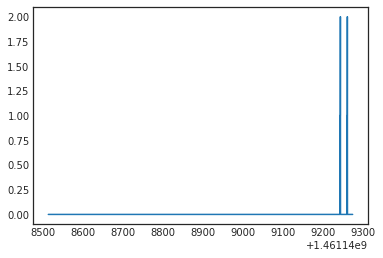

In [24]:
plt.plot( 'Timestamp', 'Label', data=df_data_1)

In [3]:
print(df_data_1.shape)

(16220, 20)


In [25]:
print (df_data_1.dtypes)

Timestamp                               float64
Label                                     int64
MotorData.ActCurrent                      int64
MotorData.ActPosition                     int64
MotorData.ActSpeed                        int64
MotorData.IsAcceleration                  int64
MotorData.IsForce                         int64
MotorData.Motor_Pos1reached               int64
MotorData.Motor_Pos2reached               int64
MotorData.Motor_Pos3reached               int64
MotorData.Motor_Pos4reached               int64
NVL_Recv_Ind.GL_Metall                    int64
NVL_Recv_Ind.GL_NonMetall                 int64
NVL_Recv_Storage.GL_I_ProcessStarted      int64
NVL_Recv_Storage.GL_I_Slider_IN           int64
NVL_Recv_Storage.GL_I_Slider_OUT          int64
NVL_Recv_Storage.GL_LightBarrier          int64
NVL_Send_Storage.ActivateStorage          int64
PLC_PRG.Gripper                           int64
PLC_PRG.MaterialIsMetal                   int64
dtype: object


Let's look at a statistical summary of each features in the dataset.

In [9]:
print(df_data_1.describe())

          Timestamp         Label  MotorData.ActCurrent  \
count  1.622000e+04  16220.000000          16220.000000   
mean   1.461149e+09      0.003761             -4.714057   
std    2.195389e+02      0.071437            397.293682   
min    1.461149e+09      0.000000          -1181.000000   
25%    1.461149e+09      0.000000           -174.000000   
50%    1.461149e+09      0.000000              3.000000   
75%    1.461149e+09      0.000000            189.000000   
max    1.461149e+09      2.000000           1181.000000   

       MotorData.ActPosition  MotorData.ActSpeed  MotorData.IsAcceleration  \
count           16220.000000        16220.000000              16220.000000   
mean           207315.832922          139.400247                 -1.587670   
std            107775.856354        57928.033474                513.080888   
min             22011.000000      -422617.000000              -3045.000000   
25%            140012.000000       -53352.750000                  0.000000   


From the summary metrics, we can see there is a huge variance in the ranges for each feature. It's good practice to normalize your data as it brings all the samples in the same scale and range. We'll do this when we come to build the models.

Let's do a quick test for data quality, even though we can assume that it is good. In the following code, we are looking for the number missing values. Missing data is one type of data quality issue, and probably the most common, but there are more. For example, in asset data, we often find the same install dates for all assets in the system, which is often a data entry mistake. For this exercise, we will only focus on missing data. As you can see, we don't have any missing data, which is great.

In [17]:
df_data_1.isnull().sum().sum()

0

Let's check out the distribution of the target variable to see the extent of the class imbalance. We'll use a bar chart to illustrate it as well as return the numerical breakdown.

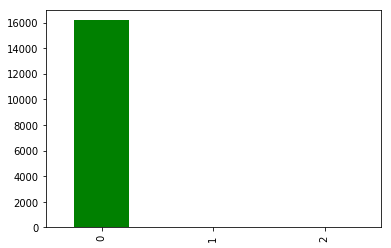

In [13]:
df_data_1.Label.value_counts().plot(kind = 'bar', color = 'green')

In [5]:
print(df_data_1.groupby('Label').size())

Label
0    16170
1       39
2       11
dtype: int64


We can see there are over sixteen thousands examples of no anomaly, and only 50 examples of anomalies: 39 examples of type 1 and only 11 of anomaly type 2.

We now look at skew, which measures the aysemmetry of the distribution of each feature ie how much a distribution has shifted to the left or right. It is important to understand this for data preparation as many machine learning algorithms assume a normal distibution.

The skew results show a positive (right) or negative (left) skew. Values closer to zero have less skew.

In [4]:
skewdf = df_data_1.skew()
print(skewdf)

Timestamp                               -0.000356
Label                                   21.322937
MotorData.ActCurrent                     0.075048
MotorData.ActPosition                   -0.062640
MotorData.ActSpeed                      -0.156669
MotorData.IsAcceleration                 0.126969
MotorData.IsForce                        0.052892
MotorData.Motor_Pos1reached              3.565379
MotorData.Motor_Pos2reached              2.070630
MotorData.Motor_Pos3reached              1.543688
MotorData.Motor_Pos4reached              3.694801
NVL_Recv_Ind.GL_Metall                   3.527928
NVL_Recv_Ind.GL_NonMetall               -3.527928
NVL_Recv_Storage.GL_I_ProcessStarted     2.046579
NVL_Recv_Storage.GL_I_Slider_IN         -1.916613
NVL_Recv_Storage.GL_I_Slider_OUT         2.193000
NVL_Recv_Storage.GL_LightBarrier       -20.064320
NVL_Send_Storage.ActivateStorage         6.752209
PLC_PRG.Gripper                         -0.063416
PLC_PRG.MaterialIsMetal                  2.581672


We can see there is significant skew in features like NVL_Recv_Storage.GL_LightBarrier and NVL_Send_Storage.ActivateStorage.

Let's examine the features in more detail. We will create box plots and histograms of each feature. These visualizations will help us better understand the range of values for each feature.

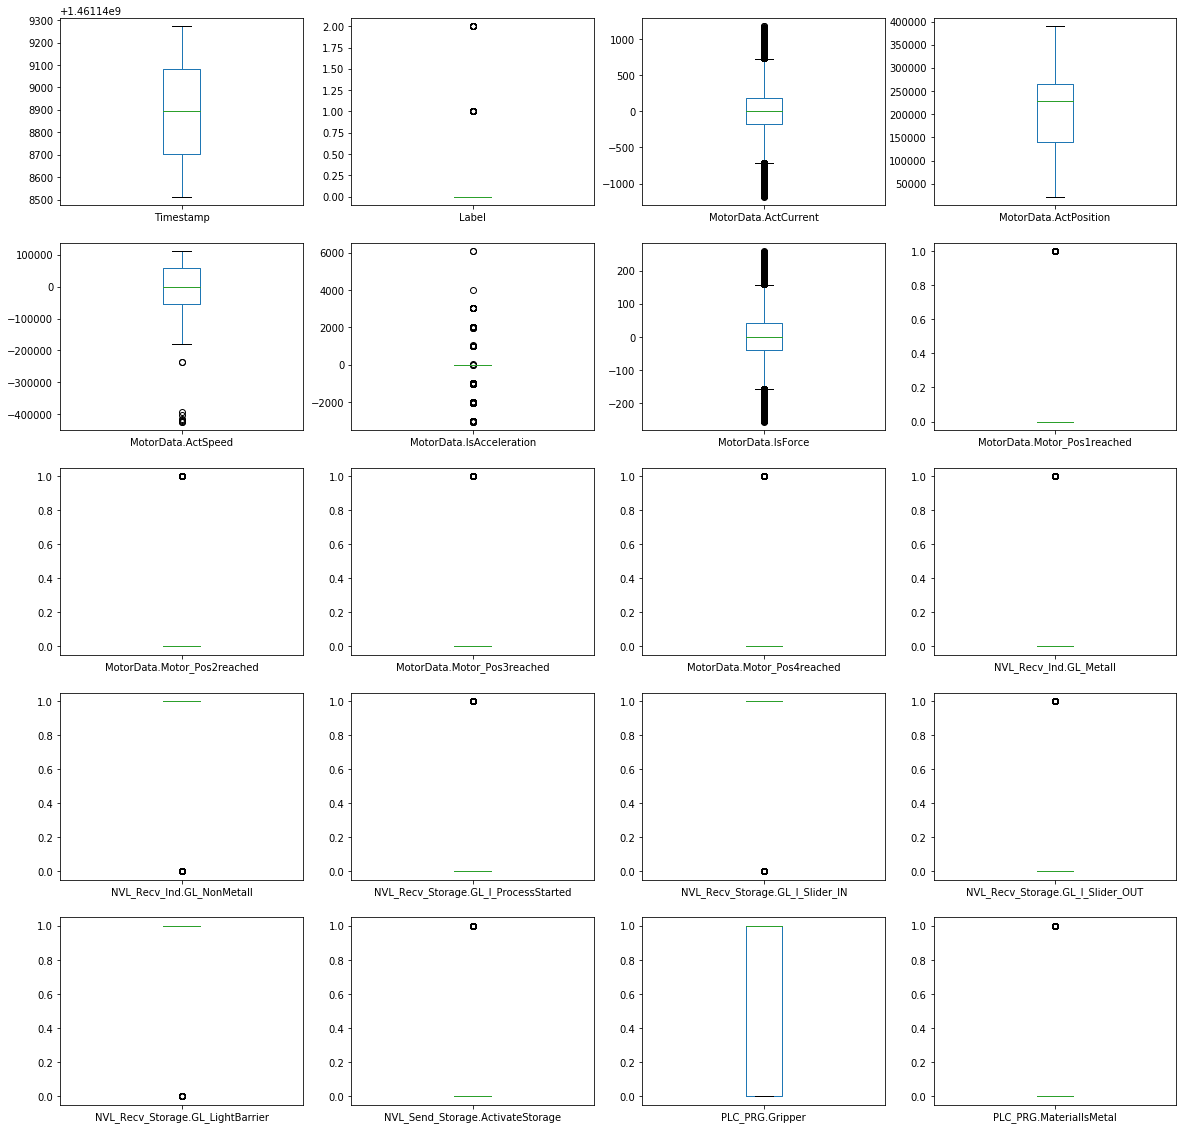

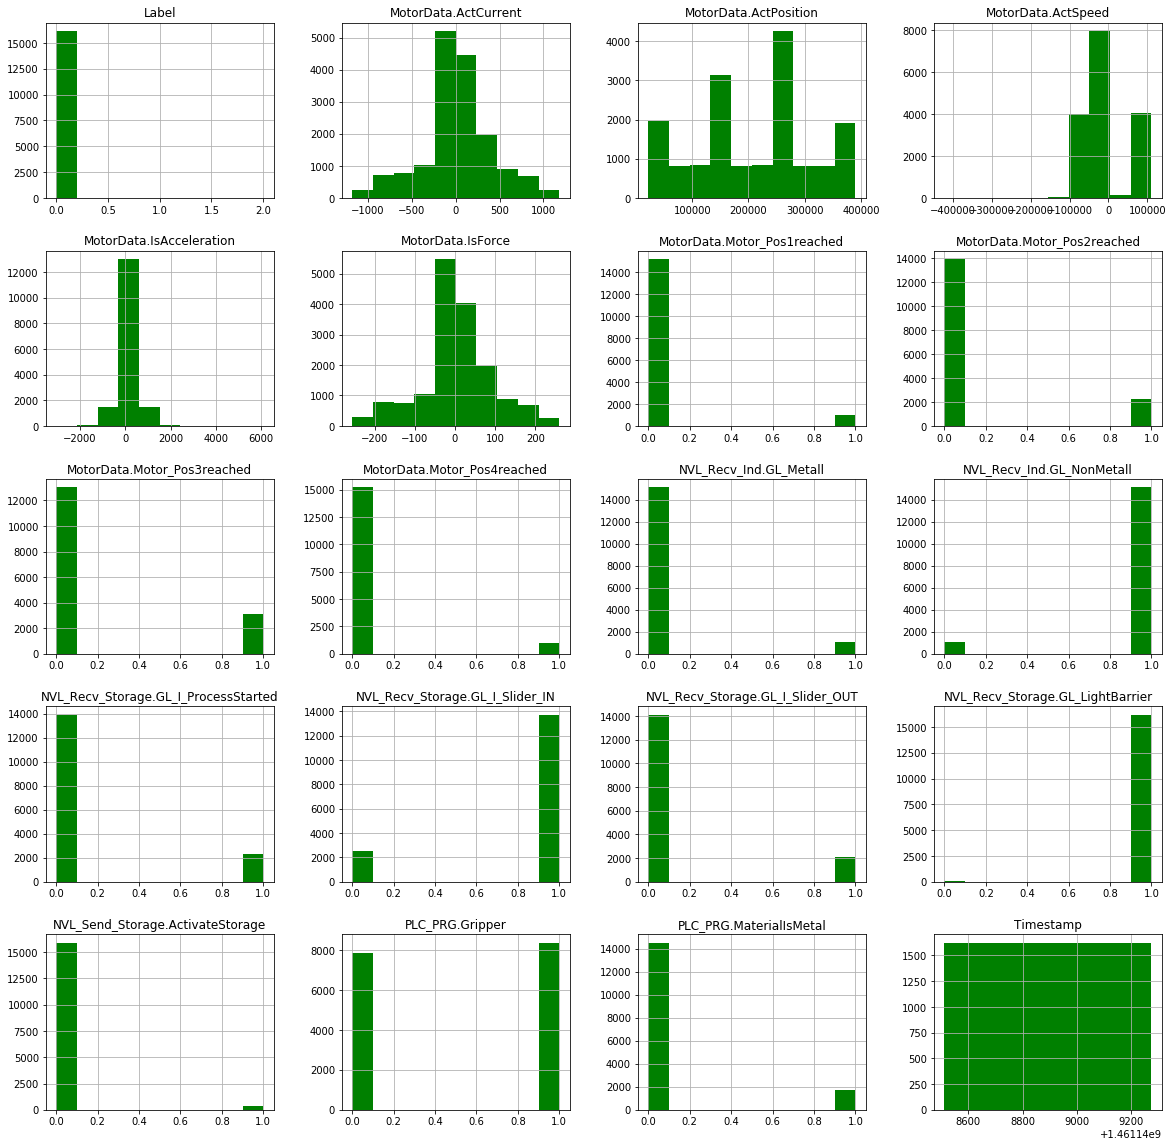

In [26]:
df_data_1.plot(kind='box', subplots=True, figsize=(20,20), layout=(5,4), sharex=False, sharey=False)
plt.show()

df_data_1.hist(figsize=(20,20), layout=(5,4), color = 'green')
plt.show()

Next, we'll plot a correlation matrix. A correlation matrix illustrates correlation coefficients between sets of features. Each feature in the matrix is correlated with each of the other features in the matrix. This enables us to see which pairs have the highest correlation.

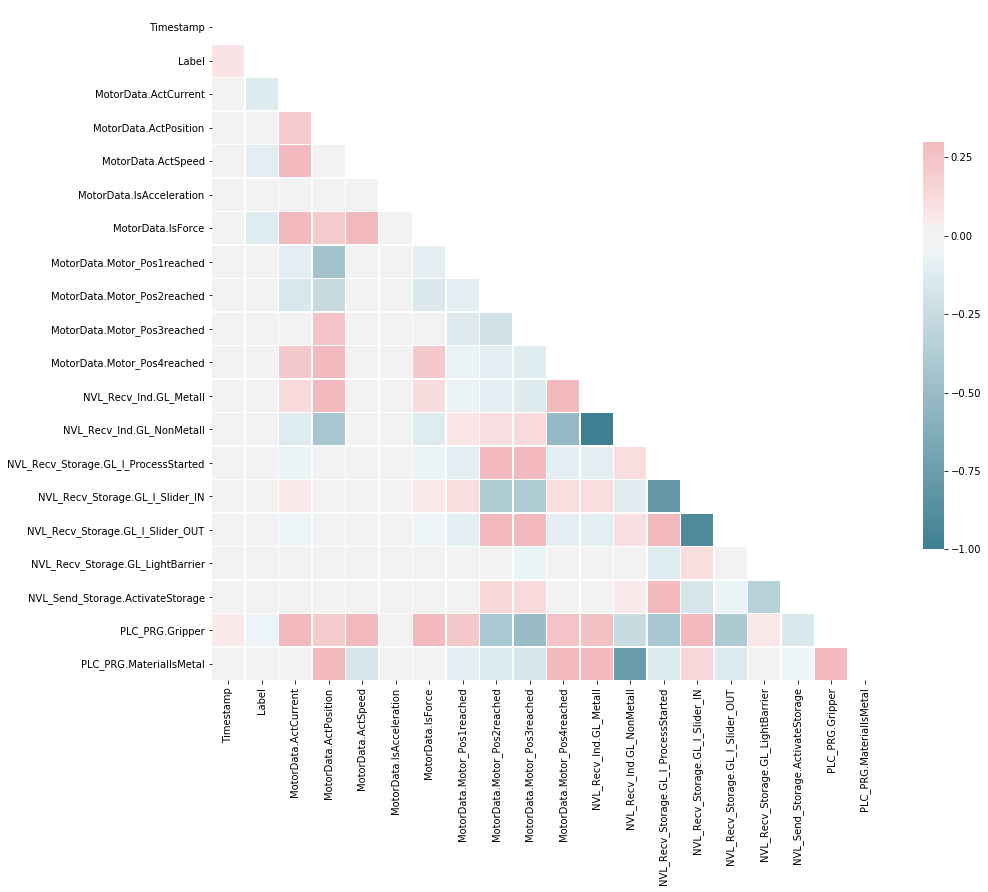

In [5]:
cov = df_data_1.corr()
fig = plt.figure(figsize = (15,15))

mask = np.zeros_like(cov, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sb.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(cov, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

As we can see from the matrix, there is negative correlations between features like NVL_Recv_Storage.GL_I_Slider_IN and NVL_Recv_Storage.GL_I_Slider_OUT, which makes intuitive sense – if the slider is in, then it can’t be out! We see some positive correlation between several features, for example MotorData.IsForce and MotorData.ActCurrent, but none high enough to be of interest. However, the high negative correlation might be an issue for us as some algorithms do not handle those features very well. This phenomonem is known as multicollinearity, and is something we will need to address during data prepartions, which is the next stage in the process.

# Data preparation

In the next section, we will prepare the data for our analysis. 

You might recall from data understanding that the timestamp column is in an odd format. This is actually a UNIX timestamp, and to make it more readable, we’ll need to convert to regular data time format.

In [6]:
df_data_1['Timestamp']=(pd.to_datetime(df_data_1['Timestamp'],unit='s'))

In [4]:
(df_data_1)

,Timestamp,Label,MotorData.ActCurrent,MotorData.ActPosition,MotorData.ActSpeed,MotorData.IsAcceleration,MotorData.IsForce,MotorData.Motor_Pos1reached,MotorData.Motor_Pos2reached,MotorData.Motor_Pos3reached,MotorData.Motor_Pos4reached,NVL_Recv_Ind.GL_Metall,NVL_Recv_Ind.GL_NonMetall,NVL_Recv_Storage.GL_I_ProcessStarted,NVL_Recv_Storage.GL_I_Slider_IN,NVL_Recv_Storage.GL_I_Slider_OUT,NVL_Recv_Storage.GL_LightBarrier,NVL_Send_Storage.ActivateStorage,PLC_PRG.Gripper,PLC_PRG.MaterialIsMetal
0,2016-04-20 10:35:12.937999964,0,-5,268975,0,0,-1,0,0,0,0,0,1,0,1,0,1,0,0,0
1,2016-04-20 10:35:12.980000019,0,0,268975,0,0,-1,0,0,0,0,0,1,0,1,0,1,0,0,0
2,2016-04-20 10:35:13.031000137,0,-5,268975,0,0,-3,0,0,0,0,0,1,0,1,0,1,0,0,0
3,2016-04-20 10:35:13.078999996,0,0,268975,0,0,4,0,0,0,0,0,1,0,1,0,1,0,0,0
4,2016-04-20 10:35:13.122000217,0,0,268975,0,0,4,0,0,0,0,0,1,0,1,0,1,0,0,0
5,2016-04-20 10:35:13.168999910,0,0,268975,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
6,2016-04-20 10:35:13.214999914,0,-9,268975,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0
7,2016-04-20 10:35:13.266000032,0,0,268975,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
8,2016-04-20 10:35:13.307000160,0,-5,268975,0,0,3,0,0,0,0,0,1,0,1,0,1,0,0,0
9,2016-04-20 10:35:13.353999853,0,0,268975,0,0,-1,0,0,0,0,0,1,0,1,0,1,0,0,0


As we saw that the NVL_Recv_Storage.GL_I_Slider_IN and NVL_Recv_Ind.GL_NonMetall are negatively correlated with other attributes, we can drop them from our data set.

In [7]:
df_data_2 = df_data_1.drop(['Timestamp','NVL_Recv_Storage.GL_I_Slider_IN', 'NVL_Recv_Ind.GL_NonMetall'], axis=1)

In [8]:
print(df_data_2.shape)

(16220, 17)


In [9]:
df_data_2

,Label,MotorData.ActCurrent,MotorData.ActPosition,MotorData.ActSpeed,MotorData.IsAcceleration,MotorData.IsForce,MotorData.Motor_Pos1reached,MotorData.Motor_Pos2reached,MotorData.Motor_Pos3reached,MotorData.Motor_Pos4reached,NVL_Recv_Ind.GL_Metall,NVL_Recv_Storage.GL_I_ProcessStarted,NVL_Recv_Storage.GL_I_Slider_OUT,NVL_Recv_Storage.GL_LightBarrier,NVL_Send_Storage.ActivateStorage,PLC_PRG.Gripper,PLC_PRG.MaterialIsMetal
0,0,-5,268975,0,0,-1,0,0,0,0,0,0,0,1,0,0,0
1,0,0,268975,0,0,-1,0,0,0,0,0,0,0,1,0,0,0
2,0,-5,268975,0,0,-3,0,0,0,0,0,0,0,1,0,0,0
3,0,0,268975,0,0,4,0,0,0,0,0,0,0,1,0,0,0
4,0,0,268975,0,0,4,0,0,0,0,0,0,0,1,0,0,0
5,0,0,268975,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,0,-9,268975,0,0,1,0,0,0,0,0,0,0,1,0,0,0
7,0,0,268975,0,0,0,0,0,0,0,0,0,0,1,0,0,0
8,0,-5,268975,0,0,3,0,0,0,0,0,0,0,1,0,0,0
9,0,0,268975,0,0,-1,0,0,0,0,0,0,0,1,0,0,0


After we have trained and built our model, we need to check how good it is on unseen data. So, we'll create a validation data set by taking 20% of the original and putting it to one side.

In [10]:
array = df_data_2.values
X = array[:,1:17]
Y = array[:,0]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

Let's do a sanity check on the spread of the target variables. As we can see, both the training and test data sets have a distribution across each class.

In [11]:
num_zeros = (Y_validation == 0).sum()
num_ones = (Y_validation == 1).sum()
num_twos = (Y_validation == 2).sum()
num_trzeros = (Y_train == 0).sum()
num_trones = (Y_train == 1).sum()
num_trtwos = (Y_train == 2).sum()
print ("Number of examples of validation label 0:", num_zeros)
print("Number of examples of validation label 1:", num_ones)
print("Number of examples of validation label 2:", num_twos)
print("Number of examples of training label 0:", num_trzeros)
print("Number of examples of training label 0:", num_trones)
print("Number of examples of training label 0:", num_trtwos)

Number of examples of validation label 0: 3232
Number of examples of validation label 1: 9
Number of examples of validation label 2: 3
Number of examples of training label 0: 12938
Number of examples of training label 0: 30
Number of examples of training label 0: 8


In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
set_printoptions(precision=4)
print(rescaledX_train[0:17,:])

[[0.4242 0.     0.7921 0.3333 0.4302 1.     0.     0.     0.     0.
  0.     0.     1.     0.     1.     0.    ]
 [0.2489 0.982  0.6127 0.4444 0.0155 0.     0.     0.     0.     0.
  0.     0.     1.     0.     1.     0.    ]
 [0.508  0.6468 0.7921 0.3333 0.5058 0.     0.     1.     0.     0.
  0.     0.     1.     0.     0.     0.    ]
 [0.7625 0.0508 0.973  0.2222 0.9477 0.     0.     0.     0.     0.
  0.     0.     1.     0.     1.     0.    ]
 [0.8743 0.993  0.9233 0.1143 0.9012 0.     0.     0.     0.     1.
  0.     0.     1.     0.     1.     1.    ]
 [0.4856 0.3053 0.67   0.4444 0.2132 0.     0.     0.     0.     0.
  0.     0.     1.     0.     0.     0.    ]
 [0.4369 0.3207 0.7921 0.3333 0.4322 0.     1.     0.     0.     0.
  1.     0.     1.     1.     0.     0.    ]
 [0.5089 0.7882 0.9468 0.3333 0.4671 0.     0.     0.     0.     0.
  0.     0.     1.     0.     1.     0.    ]
 [0.4386 0.3207 0.7921 0.3333 0.4341 0.     1.     0.     0.     0.
  1.     1.     1.     0.   

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


As we saw during the data understanding phase, there is a huge class imbalance. One technique when use to address this is to create synthetic examples to create an artificial balance. Once such algorithm to do this is ADASYN (Adaptive Synthetic) . ADASYN uses a nearest neighbors algorithm to create this artifical data for training our model.

In [13]:
X_resampled, Y_resampled = ADASYN().fit_resample(rescaledX_train, Y_train)
print(sorted(Counter(Y_resampled).items()))


[(0, 12938), (1, 12938), (2, 12938)]


Data reduction techniques can be applied to obtain a reduced representation of your data that is much smaller in
volume, yet closely maintains the integrity of the original data. Thus, machie learning  will be more
efficient yet produce more or less the same analytical results. There are many approaches to this, but for the purposes of this project we will look recursive feature elimination (RFE) whereby irrelevant, weakly relevant, or redundant features are detected and removed.  In RFE, we use an estimator algorithm (in this case LinearSVC is trained on the initial set of features and the importance of each feature is obtained. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [17]:
model = LinearSVC(random_state=0, tol=1e-5)
rfe = RFE(model, 5)
fit = rfe.fit(X_resampled, Y_resampled)
print("Num Features: %d" % fit.n_features_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 5
Feature Ranking: [ 1  4  1  2  1  9  5  8 12  7  3 10  1 11  1  6]


During the modelling phase, which is next, we will assess how useful these data preparation exercises actually are in improving the accuracy of the models. Stay tuned for that, which is next in the series!

In [19]:
models = []
models.append(('ET', ExtraTreeClassifier()))
models.append(('NC', NearestCentroid()))              
models.append(('KNN', KNeighborsClassifier()))              
models.append(('NBG', GaussianNB()))
models.append(('RCL', RidgeClassifier()))  
scoring = 'accuracy'
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X_resampled, Y_resampled, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ET: 0.990801 (0.026997)
NC: 0.947216 (0.058388)
KNN: 0.996264 (0.010867)
NBG: 0.951340 (0.064913)
RCL: 0.947449 (0.065623)


As KNN performed best, let's try and tune the parameters a bit more. The first thing is to find the optimal value for k.

In [41]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

In [42]:
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

In [43]:
grid.fit(X_resampled, Y_resampled)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=30, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [45]:
grid.cv_results_

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/Python36/

{'mean_fit_time': array([0.5088, 0.502 , 0.5085, 0.504 , 0.5098, 0.5064, 0.5072, 0.5109,
        0.5027, 0.5101, 0.5056, 0.5067, 0.5103, 0.5051, 0.5023, 0.5126,
        0.5087, 0.5075, 0.5082, 0.5078, 0.5104, 0.5082, 0.5118, 0.5112,
        0.5064, 0.5048, 0.506 , 0.5106, 0.5077, 0.512 ]),
 'std_fit_time': array([0.2962, 0.2844, 0.2968, 0.2871, 0.2919, 0.2901, 0.2918, 0.2901,
        0.2831, 0.2945, 0.2899, 0.2816, 0.2935, 0.2869, 0.278 , 0.2999,
        0.2958, 0.2856, 0.2883, 0.2909, 0.2899, 0.2839, 0.2965, 0.2947,
        0.2808, 0.2807, 0.2851, 0.2964, 0.2972, 0.2908]),
 'mean_score_time': array([0.3573, 0.3732, 0.3897, 0.3914, 0.4004, 0.4054, 0.4114, 0.4162,
        0.4216, 0.4256, 0.4282, 0.4327, 0.444 , 0.4402, 0.4434, 0.4477,
        0.4499, 0.4533, 0.4552, 0.4627, 0.4703, 0.4667, 0.4718, 0.4734,
        0.4758, 0.4796, 0.4836, 0.4847, 0.4867, 0.4928]),
 'std_score_time': array([0.0529, 0.052 , 0.0526, 0.054 , 0.0529, 0.0539, 0.0536, 0.0533,
        0.0545, 0.0531, 0.0534, 0.05

In [48]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9999484722007523
{'n_neighbors': 1}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')


## Test on unseen data
So, let's test this model on unseen data.


In [51]:
rescaledX_validation = scaler.fit_transform(X_validation)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [54]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_resampled, Y_resampled)
predictions = knn.predict(rescaledX_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.999691738594328
[[3231    1    0]
 [   0    9    0]
 [   0    0    3]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3232
           1       0.90      1.00      0.95         9
           2       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00      3244
   macro avg       0.97      1.00      0.98      3244
weighted avg       1.00      1.00      1.00      3244



# Conclusion

Wow, we can see that this performed incredibly well on unseen data too. 

Hopefully, this notebook has give you a sense of the various steps one might take in a modelling excercise. Finding the best fit for the problem you are trying to solve is iterative and experimental.

Now that you have found a good model for this type of anomaly detection, think about how you might use this in a production setting with Maximo Predictive Maintenance Insights (PMI). For example, in addition to viewing it in Maximo PMI, you might also want to create some automation scripts to trigger service requests or even work orders when an anomaly is detected. 